In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random as rnd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, random_split, DataLoader

In [ ]:
from google.colab import files
uploaded = files.upload()

For GPU support:

In [3]:
#!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl --force-reinstall

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using " + device)
device = torch.device(device)

Using cuda



Define Neural Network Encoder/Decoder Structures:

In [181]:
class ResidualBlock(nn.Module):
    def __init__(self, channel_num, kernel_size, mode='encode'):
        super().__init__()
        padd = int((kernel_size-1)/2)
        if mode=='encode':
            self.conv_block1 = nn.Sequential(
            nn.Conv1d(channel_num, channel_num, kernel_size, padding=padd),
            nn.BatchNorm1d(channel_num),
            nn.ReLU()
            ) 
            self.conv_block2 = nn.Sequential(
            nn.Conv1d(channel_num, channel_num, kernel_size, padding=padd),
            nn.BatchNorm1d(channel_num)
            )
        elif mode=='decode':
            self.conv_block1 = nn.Sequential(
            nn.ConvTranspose1d(channel_num, channel_num, kernel_size, padding=padd),
            nn.BatchNorm1d(channel_num),
            nn.ReLU()
            ) 
            self.conv_block2 = nn.Sequential(
            nn.ConvTranspose1d(channel_num, channel_num, kernel_size, padding=padd),
            nn.BatchNorm1d(channel_num)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x += residual
        out = self.relu(x)
        return out

class ResidualUnit(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size, mode='encode'):
        super().__init__()
        self.transition = False
        if channel_in != channel_out:
            self.transition = True
            if mode=='encode':
                self.dimTransition = nn.Conv1d(channel_in, channel_out, kernel_size=1)
            elif mode=='decode':
                self.dimTransition = nn.ConvTranspose1d(channel_in, channel_out, kernel_size=1)
        self.resBlk1 = ResidualBlock(channel_out, kernel_size, mode)
        self.resBlk2 = ResidualBlock(channel_out, kernel_size, mode)

    def forward(self, x):
        x = self.dimTransition(x) if self.transition else x
        x = self.resBlk1(x)
        #x = self.resBlk2(x)
        #x = self.resBlk3(x)
        return(x)


class encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.activation = nn.ReLU()
        self.pool   = nn.MaxPool1d(3)
        self.conv1  = nn.Conv1d(1, 16, 7)
        self.conv2  = nn.Conv1d(16, 32, 6)
        self.conv3  = nn.Conv1d(32, 64, 6)
        self.conv4  = nn.Conv1d(64, 128, 5) # results in size 10
        self.dense1 = nn.Linear(1280, latent_dim) # 10*128
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(32)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(0.3)
        
    def forward(self, input):
        out = self.pool(self.activation(self.conv1(input)))
        out = self.bn1(out)
        out = self.drop(out)
        out = self.pool(self.activation(self.conv2(out)))
        out = self.bn2(out)
        out = self.drop(out)
        out = self.pool(self.activation(self.conv3(out))) # 128 x 36
        out = self.bn3(out)
        out = self.drop(out)
        out = self.pool(self.activation(self.conv4(out))) # 128 x 36
        out = self.bn4(out)
        out = self.drop(out)
        out = torch.flatten(out, 1) # 128*5 = 640
        out = self.dense1(out)
        return out 

class residualEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.pool   = nn.MaxPool1d(3)
        self.drop = nn.Dropout(0.3)
        self.resUnit1 = ResidualUnit(1, 16, kernel_size=7)
        self.resUnit2 = ResidualUnit(16, 32, kernel_size=5)
        self.resUnit3 = ResidualUnit(32, 64, kernel_size=5)
        self.resUnit4 = ResidualUnit(64, 128, kernel_size=5)
        #self.resUnit5 = ResidualUnit(128,128, kernel_size=3)
        self.dense    = nn.Linear(128*12, latent_dim)

    def forward(self, x):
        x = self.pool(self.resUnit1(x))
        x = self.pool(self.resUnit2(x))
        x = self.pool(self.resUnit3(x))
        x = self.pool(self.resUnit4(x))
        x = torch.flatten(x, 1)
        x = self.dense(x)
        return x 
    
class decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.activation = nn.ReLU()
        self.dense1   = nn.Linear(latent_dim, 128*36)
        self.conv1T   = nn.ConvTranspose1d(128, 64, 7, stride=3)
        #self.resUnit1 = ResidualUnit(64, 64, kernel_size=3, mode='encode')
        self.conv2T   = nn.ConvTranspose1d(64, 32, 6, stride=3)
        self.conv3T   = nn.ConvTranspose1d(32, 16, 6, stride=3)
        self.conv4T   = nn.ConvTranspose1d(16, 1, 5)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)
        self.bn4 = nn.BatchNorm1d(16)
            
    def forward(self, input):
        out = self.activation(self.dense1(input))
        out = out.view(-1, 128, 36)
        out = self.bn1(out)
        out = self.activation(self.conv1T(out))
        out = self.bn2(out)
        #out = self.resUnit1(out)
        out = self.activation(self.conv2T(out))
        out = self.bn3(out)
        out = self.activation(self.conv3T(out))
        out = self.bn4(out)
        out = self.conv4T(out)
        return out  
    

class autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(autoencoder, self).__init__()
        #self.encoder = encoder()
        self.encoder = residualEncoder(latent_dim)
        self.decoder = decoder(latent_dim)
        
    def forward(self, input):
        encoded = self.encoder(input)
        decoded = self.decoder(encoded)
        return decoded

Data loading and preparation:

In [182]:
def loadDataSet(filename):
    with open(filename, 'rb') as f:
        dataSet = pickle.load(f)
    for _, x in dataSet:
        try:
            X = np.vstack((X, x))
        except(NameError):
            X = x
    return X


def createDataset(X, device="cpu", batch_size=10):
    # split to test / train
    n_data = len(X)
    n_train = int(0.8*n_data)
    n_test = n_data - n_train
    X = torch.tensor(X, device=device)
    dataSet = TensorDataset(X.float())
    train_dataset, test_dataset = random_split(dataSet, [n_train, n_test])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

Setup Printing functions:

In [183]:
def printTrainingHistory(alpha, batch):
    file = "train_history_alpha_" + str(alpha) + "_batch_" + str(batch)
    if os.path.isfile(file):
        with open(file, 'rb') as f:
            hist = pickle.load(f)
    else: 
        print("No history!")
        return
    train_loss = [epoch[0] for epoch in hist]
    test_loss = [epoch[1] for epoch in hist]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(train_loss, label='Train loss')
    ax.grid()
    ax.plot(test_loss, label='Test loss')
    ax.legend()
    plt.show()


def printSamplePredict(test_loader, AE, device, sample=1):
    n_subplots = 1
    plt.figure()
    with torch.no_grad():
        jdx=0
        for batch in test_loader:
            jdx+=1
            batch_in = torch.reshape(batch[0].to(device), (batch[0].size()[0], 1, 1024))
            batch_enc = AE.encoder(batch_in)
            batch_out = AE(batch_in)
            if jdx==sample:
                for idx in range(n_subplots):
                    r = rnd.randint(0, len(batch))
                    plt.subplot(n_subplots,2,idx+1)
                    plt.plot(np.squeeze(batch_in[r].cpu().detach().numpy()), label='Original')
                    plt.plot(np.squeeze(batch_out[r].cpu().detach().numpy()), '--', label='Reconstructed')
                    plt.legend()
                    plt.subplot(n_subplots,2,idx+2)
                    plt.plot(np.squeeze(batch_enc[r].cpu().detach().numpy()))
                break;
    plt.show()


Train the Autoencoder:



In [184]:
batch_size = 128
# dataset loader
print("----------- Loading data -----------")
X = loadDataSet('dataSetBig')
train_loader, test_loader = createDataset(X, device, batch_size)
print("Done")

----------- Loading data -----------
Done


---------- Creating model ----------
---------- Start training ----------
epoch : 1/160, loss = 39350.46, test loss = 37592.83
epoch : 2/160, loss = 36249.23, test loss = 34011.70
epoch : 3/160, loss = 32761.72, test loss = 31336.47
epoch : 4/160, loss = 30178.89, test loss = 30410.21
epoch : 5/160, loss = 26806.05, test loss = 27140.67
epoch : 6/160, loss = 25487.64, test loss = 24719.91
epoch : 7/160, loss = 22307.60, test loss = 23537.54
epoch : 8/160, loss = 21489.66, test loss = 22454.40
epoch : 9/160, loss = 18714.73, test loss = 20830.48
epoch : 10/160, loss = 17640.30, test loss = 18388.35
epoch : 11/160, loss = 15601.15, test loss = 17471.86
epoch : 12/160, loss = 15050.63, test loss = 16888.55
epoch : 13/160, loss = 15631.63, test loss = 19286.50
epoch : 14/160, loss = 14397.40, test loss = 16592.85
epoch : 15/160, loss = 14311.86, test loss = 14633.48
epoch : 16/160, loss = 10987.92, test loss = 12477.84
epoch : 17/160, loss = 9220.95, test loss = 11962.85
epoch : 18/160, lo

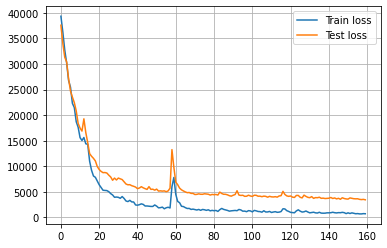

In [195]:
# hyperparameters
learning_rate = 0.01
latent_dim = 32

# instanciate model
print("---------- Creating model ----------")
AE = autoencoder(latent_dim).to(device)
optimizer = optim.Adam(AE.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# train the model
epochs = 160
alpha_thresh = 300 #0.2
track_count = 0
loss_storage = []
schedule_storage = []
print("---------- Start training ----------")
for epoch in range(epochs):

    # learning rate schedule:
    track_count += 1
    if track_count > 30:
        recent_loss = [epoch[0] for epoch in loss_storage[-30:]]
        change = np.std(recent_loss)#np.max(recent_loss) - np.min(recent_loss)
        print(change)
        if change < alpha_thresh:
            learning_rate = learning_rate / 2
            alpha_thresh = alpha_thresh / 2
            optimizer = optim.Adam(AE.parameters(), lr=learning_rate)
            print("-------- Learning rate schedule performed from {0} to {1} ----------".format(2*learning_rate,learning_rate))
            schedule_storage.append(epoch)
            track_count = 0

    loss = 0
    for batch in train_loader:
        batch_original = torch.reshape(batch[0].to(device), (batch[0].size()[0], 1, 1024)).to(device)
        
        # reset gradient
        optimizer.zero_grad() 
        
        # compute loss
        batch_decoded = AE(batch_original)
        train_loss = criterion(batch_decoded, batch_original)
        
        # compute gradient + perform gradient decent
        train_loss.backward()
        optimizer.step()
        
        loss += train_loss.item()
    
    # epoch training loss
    loss = loss / len(train_loader)
    
    # test loss
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            batch = torch.reshape(batch[0].to(device), (batch[0].size()[0], 1, 1024))
            out = AE(batch)
            test_loss += criterion(out, batch).item()
        test_loss = test_loss / len(test_loader)
    
    loss_storage.append((loss, test_loss))
        
    print("epoch : {}/{}, loss = {:.2f}, test loss = {:.2f}".format(epoch + 1, epochs, loss, test_loss)) 


print("---------- Saving results ----------")
    
torch.save(AE.encoder.state_dict(), "encoder.pth")
torch.save(AE.state_dict(), "autoencoder.pth")

with open("train_history_alpha_" + str(learning_rate) + "_batch_" + str(batch_size), "wb") as fp:
    pickle.dump(loss_storage, fp)


print("--------- Printing results ----------")

printTrainingHistory(learning_rate, batch_size)

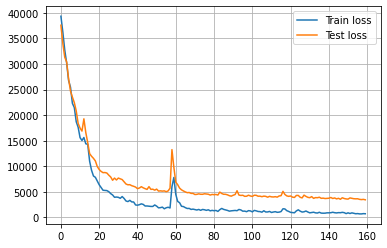

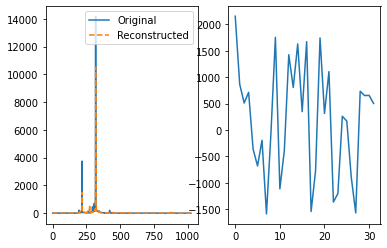

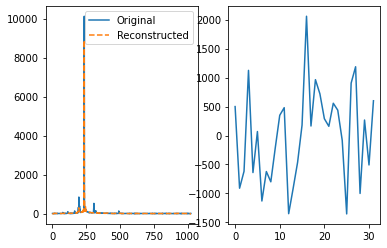

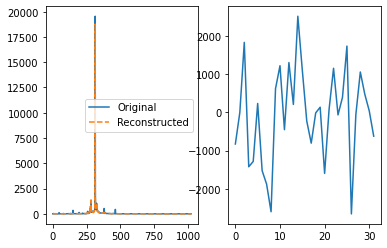

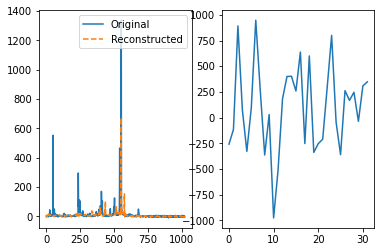

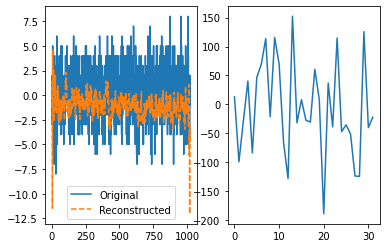

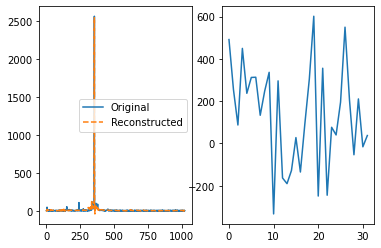

In [200]:
printTrainingHistory(learning_rate, batch_size)
for idx in range(6):
  printSamplePredict(test_loader, AE, device, sample=idx+1)